#Movie Genre Prediction

Objective
The goal of this notebook is to design a predictive model that accurately classifies movies into their respective genres based on their titles and synopses.

https://huggingface.co/spaces/competitions/movie-genre-prediction

In [ ]:
!pip install transformers datasets evaluate torchinfo contractions sentencepiece

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
data = load_dataset("datadrivenscience/movie-genre-prediction")
data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/54000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/36000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre'],
        num_rows: 54000
    })
    test: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre'],
        num_rows: 36000
    })
})

In [ ]:
df_train = data["train"].to_pandas()
genre_list = df_train['genre'].unique()

id2label = {k: v for k, v in enumerate(genre_list)}

label2id = {k: v for v, k in enumerate(genre_list)}

In [ ]:
category_count = df_train['genre'].value_counts()

categories = category_count.index

categories

Index(['fantasy', 'horror', 'family', 'scifi', 'action', 'crime', 'adventure',
       'mystery', 'romance', 'thriller'],
      dtype='object')

In [ ]:
category_count

fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: genre, dtype: int64

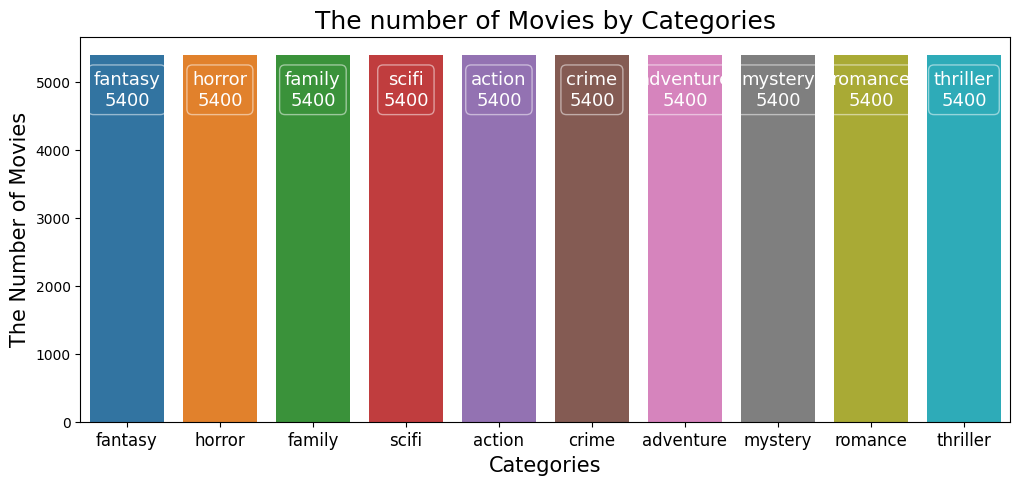

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of Movies', size= 15)

plt.xticks(size = 12)

plt.title("The number of Movies by Categories" , size = 18)

plt.show()

In [ ]:
id2label

{0: 'fantasy',
 1: 'horror',
 2: 'family',
 3: 'scifi',
 4: 'action',
 5: 'crime',
 6: 'adventure',
 7: 'mystery',
 8: 'romance',
 9: 'thriller'}

In [ ]:
label2id

{'fantasy': 0,
 'horror': 1,
 'family': 2,
 'scifi': 3,
 'action': 4,
 'crime': 5,
 'adventure': 6,
 'mystery': 7,
 'romance': 8,
 'thriller': 9}

In [ ]:
data["train"][0]

{'id': 44978,
 'movie_name': 'Super Me',
 'synopsis': 'A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.',
 'genre': 'fantasy'}

In [ ]:
# import library
import contractions

def preprocess_text(text):
  return contractions.fix(text)

In [ ]:
def add_label(sample):
    sample["label"] = label2id[sample['genre']]
    sample['text'] = preprocess_text(sample['synopsis'])
    return sample

In [ ]:
updated_data = data.map(add_label)

Map:   0%|          | 0/54000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [ ]:
updated_data["test"][0]

{'id': 16863,
 'movie_name': 'A Death Sentence',
 'synopsis': "12 y.o. Ida's dad'll die without a DKK1,500,000 operation. Ida plans to steal the money from the bank, her mom installed alarm systems in. She'll need her climbing skills, her 2 friends and 3 go-karts.",
 'genre': 'action',
 'label': 4,
 'text': "12 y.o. Ida's dad'll die without a DKK1,500,000 operation. Ida plans to steal the money from the bank, her mom installed alarm systems in. She will need her climbing skills, her 2 friends and 3 go-karts."}

In [ ]:
updated_data["train"][0]

{'id': 44978,
 'movie_name': 'Super Me',
 'synopsis': 'A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.',
 'genre': 'fantasy',
 'label': 0,
 'text': 'A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.'}

**Preprocess**

In [ ]:
#train_ds = updated_data['train']
#action_train_ds = train_ds.filter(lambda row : row['label']==1)
#action_train_ds[:6]
split_ds = updated_data['train'].train_test_split(test_size=0.2)

In [ ]:
split_ds

DatasetDict({
    train: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', 'label', 'text'],
        num_rows: 43200
    })
    test: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', 'label', 'text'],
        num_rows: 10800
    })
})

In [ ]:
#checkpoint = 'xlnet-base-cased'
#checkpoint = 'distilbert-base-uncased'
#checkpoint = 'roberta-base'
checkpoint = 'microsoft/DeBERTa-v3-large'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
  Trainer, TrainingArguments

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
result = tokenizer(updated_data['train']['movie_name'][0],updated_data['train']['text'][0])

In [ ]:

print(result)

{'input_ids': [1, 2479, 2436, 2, 336, 856, 102019, 2351, 2678, 2869, 3296, 396, 292, 315, 782, 24155, 265, 411, 20186, 293, 266, 14909, 260, 15685, 349, 682, 417, 2241, 260, 2], 'token_type_ids': [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
result.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokenizer.decode(result['input_ids'])

'[CLS] Super Me[SEP] A young scriptwriter starts bringing valuable objects back from his short nightmares of being chased by a demon. Selling them makes him rich.[SEP]'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=10, id2label=id2label, label2id=label2id
)
model.cuda()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DeBERTa-v3-large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [ ]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                             Param #
XLNetForSequenceClassification                     --
├─XLNetModel: 1-1                                  768
│    └─Embedding: 2-1                              24,576,000
│    └─ModuleList: 2-2                             --
│    │    └─XLNetLayer: 3-1                        7,678,464
│    │    └─XLNetLayer: 3-2                        7,678,464
│    │    └─XLNetLayer: 3-3                        7,678,464
│    │    └─XLNetLayer: 3-4                        7,678,464
│    │    └─XLNetLayer: 3-5                        7,678,464
│    │    └─XLNetLayer: 3-6                        7,678,464
│    │    └─XLNetLayer: 3-7                        7,678,464
│    │    └─XLNetLayer: 3-8                        7,678,464
│    │    └─XLNetLayer: 3-9                        7,678,464
│    │    └─XLNetLayer: 3-10                       7,678,464
│    │    └─XLNetLayer: 3-11                       7,678,464
│    │    └─XLNetLayer: 3-12                 

In [ ]:
def preprocess_function(batch):
    return tokenizer(batch['movie_name'],batch['text'], truncation=True)

tokenized_text = split_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/43200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/10800 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
import shutil
shutil.rmtree('movie_genre_classification_model-v8')

FileNotFoundError: ignored

Fine-tuning with the TFTrainer class

In [ ]:
training_args = TrainingArguments(
    output_dir="movie_genre_classification_model-v7",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_text["train"],
    eval_dataset=tokenized_text["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/dassum/movie_genre_classification_model-v7 into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.752600,1.667887,0.411204
2,1.617700,1.636166,0.414907
3,1.542200,1.645487,0.419907
4,1.481100,1.651153,0.418333


TrainOutput(global_step=5400, training_loss=1.615003549081308, metrics={'train_runtime': 1190.0176, 'train_samples_per_second': 145.208, 'train_steps_per_second': 4.538, 'total_flos': 6688827300331776.0, 'train_loss': 1.615003549081308, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 1.6053435802459717,
 'eval_accuracy': 0.4222222222222222,
 'eval_runtime': 59.4517,
 'eval_samples_per_second': 181.66,
 'eval_steps_per_second': 11.354,
 'epoch': 5.0}

In [ ]:
trainer.save_model('movie_genre_classification_model-v7')
trainer.push_to_hub()

Upload file runs/Jul25_16-14-51_82005dc40f70/events.out.tfevents.1690301879.82005dc40f70.29032.0:   0%|       …

Upload file runs/Jul25_16-14-51_82005dc40f70/events.out.tfevents.1690305030.82005dc40f70.29032.1:   0%|       …

To https://huggingface.co/dassum/movie_genre_classification_model-v7
   bd5e4d5..a365872  main -> main

   bd5e4d5..a365872  main -> main

To https://huggingface.co/dassum/movie_genre_classification_model-v7
   a365872..0e5f2c4  main -> main

   a365872..0e5f2c4  main -> main



**Loading Pre-Trained Model**

In [ ]:
!ls movie_genre_classification_model-v7

checkpoint-2700  merges.txt	    special_tokens_map.json  vocab.json
checkpoint-5400  pytorch_model.bin  tokenizer_config.json    vocab.txt
checkpoint-8100  README.md	    tokenizer.json
config.json	 runs		    training_args.bin


In [ ]:
from transformers import pipeline

savedmodel = pipeline('text-classification',model="dassum/movie_genre_classification_model-v7",framework='pt', device=0)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
updated_data["test"][0]

{'id': 16863,
 'movie_name': 'A Death Sentence',
 'synopsis': "12 y.o. Ida's dad'll die without a DKK1,500,000 operation. Ida plans to steal the money from the bank, her mom installed alarm systems in. She'll need her climbing skills, her 2 friends and 3 go-karts.",
 'genre': 'action',
 'label': 4,
 'text': "12 y.o. Ida's dad will die without a DKK1,500,000 operation. Ida plans to steal the money from the bank, her mom installed alarm systems in. She will need her climbing skills, her 2 friends and 3 go-karts."}

In [ ]:
res = savedmodel({'text': updated_data["test"]['movie_name'][0], 'text_pair': updated_data["test"]['text'][0]})
res['label']

'family'

In [ ]:
test_df = updated_data['test'].to_pandas()
test_df.head()
test_df = test_df.reset_index()

predictions = []
test_ids = []
actuals_ids = []
predictions_ids = []
for row in test_df.itertuples(index=True, name='Pandas'):
    print(row.id)
    test_ids.append(row.id)
    prediction_value_pt = savedmodel({'text': row.movie_name, 'text_pair': row.text})
    label = prediction_value_pt['label']
    predictions.append(label)
    actuals_ids.append(row.label)
    predictions_ids.append(label2id[label])

16863
48456
41383
84007
40269
16524
21245
84681
73352
37966


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Streaming output truncated to the last 5000 lines.
31438
14607
37644
28933
15661
6677
15294
41675
73143
43611
71819
749
12858
54080
28321
17959
26084
5477
33842
84872
18584
59674
7192
18540
29470
2054
28646
8325
70287
86090
4991
49881
67003
66178
32047
47566
1787
45351
49174
87936
55351
13412
15361
31602
22937
19928
26032
80805
46696
78172
87143
77556
68174
86112
88781
30804
3713
72766
80683
14560
73414
9358
6800
74274
41812
76845
53645
77540
25872
31392
52525
18558
59747
79426
50044
42442
17128
37898
68966
49069
22559
33757
33873
56177
34966
81887
863
24698
75346
75386
77212
73341
9428
21162
43946
89280
21137
14773
27941
15112
11794
41617
78331
4867
57982
72045
81955
83507
49298
80596
86511
12884
63973
15576
32928
44987
12164
54810
83545
34574
17709
13969
3572
42372
79125
39260
11808
72919
6712
26700
37047
54011
71476
36247
20050
26051
59981
20672
77126
48582
47137
79500
84973
51626
65841
4282
35455
40783
73230
49291
22223
55924
80226
8172
23614
9364
67760
45437
61280
62927
37190
1708

In [ ]:
print(len(test_ids))

36000


In [ ]:
import numpy as np
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%s'],
    delimiter=',',
    header='id,genre',
    comments='',
)

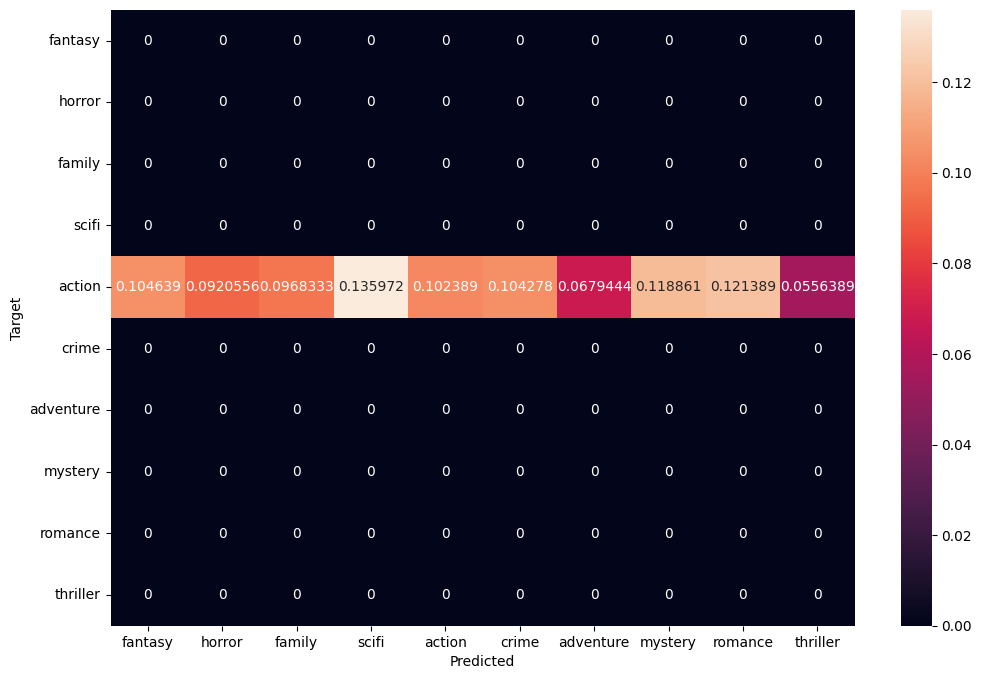

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['fantasy', 'horror', 'family','scifi','action','crime','adventure','mystery','romance','thriller']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(actuals_ids, predictions_ids, normalize='true')
plt.figure(figsize = (12,8))
plot_cm(cm)